# Development

In [1]:
import math
from os import remove
import warnings
import time

# standard scientific
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
# ! pip install zarr

# gee
import ee

# raster stuff
import dask.distributed
import pystac_client
import rioxarray  # noqa: F401
import contextily
import rasterio
import shapely.geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from ast import literal_eval
from os.path import join
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, shape

from importlib import reload
import viz_utils
import data_utils
from event import Event, pwater_thresh

plt.rcParams['font.family'] = 'Arial'

# set up env
bd = '.'
wd = join(bd, "..", "data")

# event
storm = "batsirai"
region = "mananjary"
nsubregions = 1
subregion = 0

In [2]:
# load event GeoDataFrame (as when getting data)
event = Event(storm, region, nsubregions, wd, bd)
event.make_grids()
event.get_all_features(subregion)

# Try and load a GFM dataset

In [4]:
# event
storm = "ian"
region = "cuba"
nsubregions = 69
subregion = 0

In [7]:
# load event GeoDataFrame (as when getting data)
event = Event(storm, region, nsubregions, wd, bd)
event.make_grids()
event.get_all_features(subregion)

100%|████████████████████████████████████| 4096/4096 [00:00<00:00, 19625.48it/s]
ian_cuba_0: error adding extra flood info:
"['det_method', 'obj_desc'] not in index"
Creating empty fields
Error for mslp for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for sp for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for u10_u for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for u10_v for ian, cuba, 0:Image.reduceRegions: Need 1 bands for Reducer.mean, image has 0.
Creating empty field.
Error for soiltemp1 for ian, cuba, 0:Image.clip: Parameter 'input' is required.
Creating empty field.
Error for soiltemp2 for ian, cuba, 0:Image.clip: Parameter 'input' is required.
Creating empty field.
100%|████████████████████████████████████| 4096/4096 [00:00<00:00, 23589.29it/s]


In [8]:
feature_gdf = event.feature_gdf[subregion]

<AxesSubplot:>

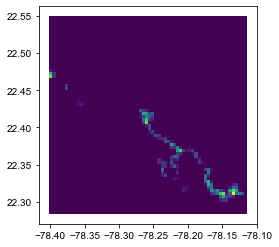

In [13]:
feature_gdf.plot('floodfrac')

In [14]:
event.process_all_subregions()

Creating empty field.
Creating empty field.
ERROR:fiona._env:./../data/ian_cuba/feature_stats_1.gpkg: No such file or directory
100%|████████████████████████████████████| 4096/4096 [00:00<00:00, 19082.40it/s]
"['det_method', 'obj_desc'] not in index"
Creating empty fields
Creating empty field.
Creating empty field.
Creating empty field.
Creating empty field.


KeyboardInterrupt: 

# Get vegetation and JRC layers (without gridding)

In [30]:
def get_ndvi(self, subregion, recalculate=False):
    """NDVI (reprojected and masked from mangroves)"""

    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    self.logger.info("Calculating NDVI...")

    try:
        # set up Google Earth Engine for subregion
        if self.connected_to_gee != subregion: self.start_gee(subregion)
        aoi_ee = self.aoi_ee[subregion]
        grid_ee = self.grid_ee[subregion]

        # NDVI
        ndvi = ee.Image(ee.ImageCollection("MODIS/006/MOD13Q1")
                        .filterBounds(aoi_ee)
                        .filterDate(ee.Date(self.startdate).advance(-2, 'month'), ee.Date(self.enddate))
                        .mean()
                        .clip(aoi_ee))

        ndvi = ndvi.select('NDVI')
        ndvi = ndvi.unmask(0)

    except Exception as e:
        print("Didn't work")

    return(ndvi)



def get_permwater(self, band, subregion, recalculate=False):
    """Get JRC Permanent water from Google Earth Engine.

    JRC permanent water dataset: 30 arcseconds (approx. 1km). Needs a better way to impute missing ocean values.
    """
    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    
    self.logger.info("Recalculating permanent water...")

    try:
        if self.connected_to_gee != subregion:
            self.start_gee(subregion)

        aoi_ee = self.aoi_ee[subregion]
        grid_ee = self.grid_ee[subregion]

        jrc_permwater = (ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
                         .clip(aoi_ee)
                         .select(band)
                         .unmask(0))

    except Exception as e:
        print("Didn't work")
    
    return jrc_permwater


def get_lulc(self, subregion, recalculate=False):
    """Land use and land cover."""

    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)


    # set up Google Earth Engine for subregion
    if self.connected_to_gee != subregion: self.start_gee(subregion)
    aoi_ee = self.aoi_ee[subregion]
    grid_ee = self.grid_ee[subregion]

    self.logger.info(f"Calculating dominant LULC type per grid cell...")
    try:
        lulc = ee.Image(ee.ImageCollection("ESA/WorldCover/v100")
                          .filterBounds(aoi_ee)
                          .mode()
                          .clip(aoi_ee)
                          .unmask(0))

    except Exception as e:
        print("Didn't work")

    # save output
    return lulc

In [36]:
for subregion in range(nsubregions):
#     ndvi = get_ndvi(event, subregion)

#     # define path to assets to download file
#     assexport_drive = ee.batch.Export.image.toDrive(ndvi,
#                                                     description=f'NDVI_{storm}_{region}_{subregion}',
#                                                     folder=f"{storm}_{region}_{subregion}",
#                                                     fileNamePrefix=f"NDVI_{subregion}",
#                                                     scale=10,
#                                                     maxPixels=1e9)

#     # export to google earth engine account
#     assexport_drive.start()

#     while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
#         print('Still running...')
#         time.sleep(10)

#     print("Finished!")

#     jrc_permwater = get_permwater(event, 'occurence', subregion)

#     # define path to assets to download file
#     assexport_drive = ee.batch.Export.image.toDrive(jrc_permwater,
#                                                     description=f'JRC_{storm}_{region}_{subregion}',
#                                                     folder=f"{storm}_{region}_{subregion}",
#                                                     fileNamePrefix=f"JRC_PW_{subregion}",
#                                                     scale=10,
#                                                     maxPixels=1e9)

#     # export to google earth engine account
#     assexport_drive.start()

#     while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
#         print('Still running...')
#         time.sleep(10)

#     print("Finished!")
    
    jrc_permwater = get_permwater(event, 'seasonality', subregion)

    # define path to assets to download file
    assexport_drive = ee.batch.Export.image.toDrive(jrc_permwater,
                                                    description=f'JRC_{storm}_{region}_{subregion}',
                                                    folder=f"{storm}_{region}_{subregion}",
                                                    fileNamePrefix=f"JRC_PW_seasonal_{subregion}",
                                                    scale=10,
                                                    maxPixels=1e9)

    # export to google earth engine account
    assexport_drive.start()

    while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
        print('Still running...')
        time.sleep(10)

    print("Finished!")
    
    
    lulc = get_lulc(event, subregion)

    # define path to assets to download file
    assexport_drive = ee.batch.Export.image.toDrive(lulc,
                                                    description=f'LULC_{storm}_{region}_{subregion}',
                                                    folder=f"{storm}_{region}_{subregion}",
                                                    fileNamePrefix=f"LULC_{subregion}",
                                                    scale=10,
                                                    maxPixels=1e9)

    # export to google earth engine account
    assexport_drive.start()

    while (assexport_drive.status()['state'] == 'RUNNING') or (assexport_drive.status()['state'] == 'READY'):
        print('Still running...')
        time.sleep(10)

    print("Finished!")


Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Finished!
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Still running...
Finished!


In [33]:
assexport_drive.status()

{'state': 'COMPLETED',
 'description': 'LULC_batsirai_mananjary_0',
 'creation_timestamp_ms': 1665674686433,
 'update_timestamp_ms': 1665675016331,
 'start_timestamp_ms': 1665674824232,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1N1z1O4LZcd3iagr5Au3wEQBESOQvUsuz'],
 'attempt': 1,
 'id': 'XDBR7XPJ62ZRTO6N36ZYHFC5',
 'name': 'projects/earthengine-legacy/operations/XDBR7XPJ62ZRTO6N36ZYHFC5'}

# Auxilliary spatial features

In [4]:
# features along shortest line to permanent water
from data_utils import features_to_process
event.add_intermediates_to_event(subregion, features_to_process, thresh=pwater_thresh)
line_gdf.replace(np.nan, 0.0).plot('ndvi_to_pw', cmap='YlGn', legend=True)

100%|██████████████████████████████████████| 1833/1833 [00:06<00:00, 281.72it/s]


# Deltares Flood Hazard Maps

In [ ]:
def get_deltares(self, subregion, recalculate=False):
    """Download Deltares flood data.

    Deltares coastal flood hazard data.
    """
    if self.feature_gdf[subregion] is None: self.get_gdf(subregion)

    # get data from GEE
    if "deltares" not in self.feature_gdf[subregion] or recalculate:
        feature_gdf = self.feature_gdf[subregion]

        try:
            if self.connected_to_gee != subregion:
                self.start_gee(subregion)

            # cycle through all rps
            rp = 100
            slr = 2018
            minx, miny, maxx, maxy = feature_gdf.unary_union.bounds

            # load deltares data
            client = dask.distributed.Client(processes=False)
            catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")
            search = catalog.search(
                collections=["deltares-floods"],
                query={
                    "deltares:dem_name": {"eq": "NASADEM"},
                    "deltares:sea_level_year": {"eq": slr},
                    "deltares:return_period": {"eq": rp},
                },
            )
            item = next(search.get_items())
            url = item.assets["index"].href
            ds = xr.open_dataset(f"reference::{url}", engine="zarr", consolidated=False, chunks={})
            ds_aoi = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx), time=ds.time[0])
            flooded = ds_aoi.inun.where(ds_aoi.inun > 0, 0)
            flooded = flooded.where(flooded==0, 1)
            flooded.rio.set_crs('epsg:4326');

            # convert to src and overlay to feature stats grid
            flooded.rio.to_raster('src_temp.tiff')
            src = rasterio.open('src_temp.tiff')
            remove('src_temp.tiff')

            feature_gen = rasterio.features.dataset_features(src, geographic=True, as_mask=True)
            feature_list = [feature for feature in feature_gen]
            geom = [shape(i['geometry']) for i in feature_list]
            values = [i['properties']['val'] for i in feature_list]
            flood_gdf = gpd.GeoDataFrame({'geometry':geom}).set_crs(4326)

            feature_gdf = data_utils.get_grid_intersects(flood_gdf, feature_gdf, floodcol='deltares')

        except Exception as e:
            self.logger.error(f"Error for Deltares data for {self.storm}, {self.region}, {subregion}:"\
                                f"\n{e}\n\nCreating empty fields.")
            feature_gdf["deltares"] = [""] * len(feature_gdf)

        self.feature_gdf[subregion] = feature_gdf
        #self.save_gdf(subregion)

In [10]:
get_deltares(event, subregion)
event_gdf = event.feature_gdf[subregion]

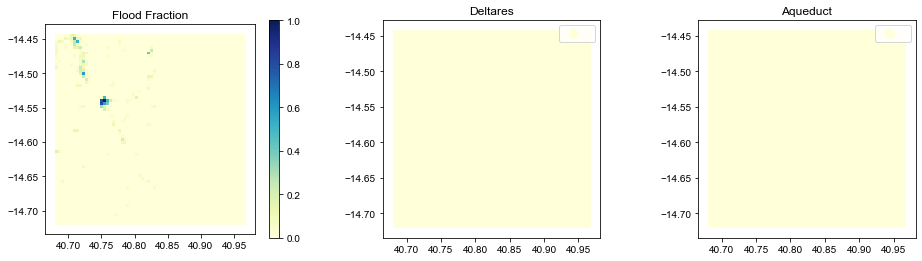

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
event_gdf.plot('floodfrac', ax=ax[0], legend=True, cmap='YlGnBu')
event_gdf.plot('deltares', ax=ax[1], legend=True, cmap='YlGnBu')
event_gdf.plot('aqueduct', ax=ax[2], legend=True, cmap='YlGnBu')

ax[0].set_title('Flood Fraction')
ax[1].set_title('Deltares')
ax[2].set_title('Aqueduct');